In [1]:
#importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_columns', None)

In [2]:
data1 = pd.read_csv('C:/Data_Science/Personal_Notebooks/Podcast_listening_time_prediction/train.csv')
data2 = pd.read_csv('C:/Data_Science/Personal_Notebooks/Podcast_listening_time_prediction/test.csv')

train = data1.copy()
test = data2.copy()

train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [3]:
train = train.fillna(train.median(numeric_only= True))
test = test.fillna(test.median(numeric_only= True))

In [4]:
from my_functions import lower_case

lower_case(train, ['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
        'Genre', 'Host_Popularity_percentage', 'Publication_Day',
        'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
        'Episode_Sentiment', 'Listening_Time_minutes'])

lower_case(test, ['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
        'Genre', 'Host_Popularity_percentage', 'Publication_Day',
        'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
        'Episode_Sentiment'])

In [5]:
days_encoding = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

train['weekday_encoded'] = train['publication_day'].map(days_encoding)

test['weekday_encoded'] = test['publication_day'].map(days_encoding)

publication_encoding = {
    'Morning': 0,
    'Afternoon': 1,
    'Evening': 2,
    'Night': 4
}

train['publication_encoded'] = train['publication_time'].map(publication_encoding)

test['publication_encoded'] = test['publication_time'].map(publication_encoding)

train = train.drop(columns=['publication_day', 'publication_time'])

test = test.drop(columns=['publication_day', 'publication_time'])

print("Train df after encoding of day and time: \n", train.head(3))
print("Test df after encoding of day and time: \n", test.head(3))

Train df after encoding of day and time: 
    id     podcast_name episode_title  episode_length_minutes       genre  \
0   0  Mystery Matters    Episode 98                   63.84  True Crime   
1   1    Joke Junction    Episode 26                  119.80      Comedy   
2   2   Study Sessions    Episode 16                   73.90   Education   

   host_popularity_percentage  guest_popularity_percentage  number_of_ads  \
0                       74.81                        53.58            0.0   
1                       66.95                        75.95            2.0   
2                       69.97                         8.97            0.0   

  episode_sentiment  listening_time_minutes  weekday_encoded  \
0          Positive                31.41998                4   
1          Negative                88.01241                6   
2          Negative                44.92531                2   

   publication_encoded  
0                    4  
1                    1  
2          

In [6]:
episode_mapping = {
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2
}

train['episode_sentiment_encoded'] = train['episode_sentiment'].map(episode_mapping)
test['episode_sentiment_encoded'] = test['episode_sentiment'].map(episode_mapping)

train = train.drop(columns='episode_sentiment')
test = test.drop(columns='episode_sentiment')

print("Train df after encoding the sentiment: \n", train.head(3))
print("Test df after encoding the sentiment: \n", test.head(3))

Train df after encoding the sentiment: 
    id     podcast_name episode_title  episode_length_minutes       genre  \
0   0  Mystery Matters    Episode 98                   63.84  True Crime   
1   1    Joke Junction    Episode 26                  119.80      Comedy   
2   2   Study Sessions    Episode 16                   73.90   Education   

   host_popularity_percentage  guest_popularity_percentage  number_of_ads  \
0                       74.81                        53.58            0.0   
1                       66.95                        75.95            2.0   
2                       69.97                         8.97            0.0   

   listening_time_minutes  weekday_encoded  publication_encoded  \
0                31.41998                4                    4   
1                88.01241                6                    1   
2                44.92531                2                    2   

   episode_sentiment_encoded  
0                          2  
1             

In [7]:
train = train.drop(columns=['id','podcast_name', 'episode_title', 'genre'])
test = test.drop(columns=['id','podcast_name', 'episode_title', 'genre'])

In [8]:
target_placeholder = train.pop('listening_time_minutes')

train['listening_time_minutes'] = target_placeholder

train

,episode_length_minutes,host_popularity_percentage,guest_popularity_percentage,number_of_ads,weekday_encoded,publication_encoded,episode_sentiment_encoded,listening_time_minutes
0,63.84,74.81,53.58,0.0,4,4,2,31.41998
1,119.80,66.95,75.95,2.0,6,1,0,88.01241
2,73.90,69.97,8.97,0.0,2,2,0,44.92531
3,67.17,57.22,78.70,2.0,1,0,2,46.27824
4,110.51,80.07,58.68,3.0,1,1,1,75.61031
...,...,...,...,...,...,...,...,...
749995,75.66,69.36,53.58,0.0,6,0,0,56.87058
749996,75.75,35.21,53.58,2.0,6,4,1,45.46242
749997,30.98,78.58,84.89,0.0,4,0,0,15.26000
749998,108.98,45.39,93.27,0.0,4,0,0,100.72939


In [9]:
train.dtypes

episode_length_minutes         float64
host_popularity_percentage     float64
guest_popularity_percentage    float64
number_of_ads                  float64
weekday_encoded                  int64
publication_encoded              int64
episode_sentiment_encoded        int64
listening_time_minutes         float64
dtype: object

In [10]:
train['combined_popularity'] = (train['host_popularity_percentage'] / 100.0) * (train['guest_popularity_percentage'] / 100.0) *100.0
test['combined_popularity'] = (test['host_popularity_percentage'] / 100.0) * (test['guest_popularity_percentage'] / 100.0) *100.0

train['popularity_difference'] = (train['host_popularity_percentage'] - train['guest_popularity_percentage'])
test['popularity_difference'] = (test['host_popularity_percentage'] - test['guest_popularity_percentage'])

print("Train df after creation of 2 new features: \n", train.head(3))
print("Test df after creation of 2 new features: \n", test.head(3))

Train df after creation of 2 new features: 
    episode_length_minutes  host_popularity_percentage  \
0                   63.84                       74.81   
1                  119.80                       66.95   
2                   73.90                       69.97   

   guest_popularity_percentage  number_of_ads  weekday_encoded  \
0                        53.58            0.0                4   
1                        75.95            2.0                6   
2                         8.97            0.0                2   

   publication_encoded  episode_sentiment_encoded  listening_time_minutes  \
0                    4                          2                31.41998   
1                    1                          0                88.01241   
2                    2                          0                44.92531   

   combined_popularity  popularity_difference  
0            40.083198                  21.23  
1            50.848525                  -9.00  
2       

In [11]:
train

,episode_length_minutes,host_popularity_percentage,guest_popularity_percentage,number_of_ads,weekday_encoded,publication_encoded,episode_sentiment_encoded,listening_time_minutes,combined_popularity,popularity_difference
0,63.84,74.81,53.58,0.0,4,4,2,31.41998,40.083198,21.23
1,119.80,66.95,75.95,2.0,6,1,0,88.01241,50.848525,-9.00
2,73.90,69.97,8.97,0.0,2,2,0,44.92531,6.276309,61.00
3,67.17,57.22,78.70,2.0,1,0,2,46.27824,45.032140,-21.48
4,110.51,80.07,58.68,3.0,1,1,1,75.61031,46.985076,21.39
...,...,...,...,...,...,...,...,...,...,...
749995,75.66,69.36,53.58,0.0,6,0,0,56.87058,37.163088,15.78
749996,75.75,35.21,53.58,2.0,6,4,1,45.46242,18.865518,-18.37
749997,30.98,78.58,84.89,0.0,4,0,0,15.26000,66.706562,-6.31
749998,108.98,45.39,93.27,0.0,4,0,0,100.72939,42.335253,-47.88


In [12]:
weekend_days = [6, 7]

train['is_weekend'] = train['weekday_encoded'].apply(lambda x: 1 if x in weekend_days else 0)

In [13]:
train

,episode_length_minutes,host_popularity_percentage,guest_popularity_percentage,number_of_ads,weekday_encoded,publication_encoded,episode_sentiment_encoded,listening_time_minutes,combined_popularity,popularity_difference,is_weekend
0,63.84,74.81,53.58,0.0,4,4,2,31.41998,40.083198,21.23,0
1,119.80,66.95,75.95,2.0,6,1,0,88.01241,50.848525,-9.00,1
2,73.90,69.97,8.97,0.0,2,2,0,44.92531,6.276309,61.00,0
3,67.17,57.22,78.70,2.0,1,0,2,46.27824,45.032140,-21.48,0
4,110.51,80.07,58.68,3.0,1,1,1,75.61031,46.985076,21.39,0
...,...,...,...,...,...,...,...,...,...,...,...
749995,75.66,69.36,53.58,0.0,6,0,0,56.87058,37.163088,15.78,1
749996,75.75,35.21,53.58,2.0,6,4,1,45.46242,18.865518,-18.37,1
749997,30.98,78.58,84.89,0.0,4,0,0,15.26000,66.706562,-6.31,0
749998,108.98,45.39,93.27,0.0,4,0,0,100.72939,42.335253,-47.88,0


In [15]:
target_placeholder = train.pop('listening_time_minutes')

train['listening_time_minutes'] = target_placeholder

train

,episode_length_minutes,host_popularity_percentage,guest_popularity_percentage,number_of_ads,weekday_encoded,publication_encoded,episode_sentiment_encoded,combined_popularity,popularity_difference,is_weekend,listening_time_minutes
0,63.84,74.81,53.58,0.0,4,4,2,40.083198,21.23,0,31.41998
1,119.80,66.95,75.95,2.0,6,1,0,50.848525,-9.00,1,88.01241
2,73.90,69.97,8.97,0.0,2,2,0,6.276309,61.00,0,44.92531
3,67.17,57.22,78.70,2.0,1,0,2,45.032140,-21.48,0,46.27824
4,110.51,80.07,58.68,3.0,1,1,1,46.985076,21.39,0,75.61031
...,...,...,...,...,...,...,...,...,...,...,...
749995,75.66,69.36,53.58,0.0,6,0,0,37.163088,15.78,1,56.87058
749996,75.75,35.21,53.58,2.0,6,4,1,18.865518,-18.37,1,45.46242
749997,30.98,78.58,84.89,0.0,4,0,0,66.706562,-6.31,0,15.26000
749998,108.98,45.39,93.27,0.0,4,0,0,42.335253,-47.88,0,100.72939


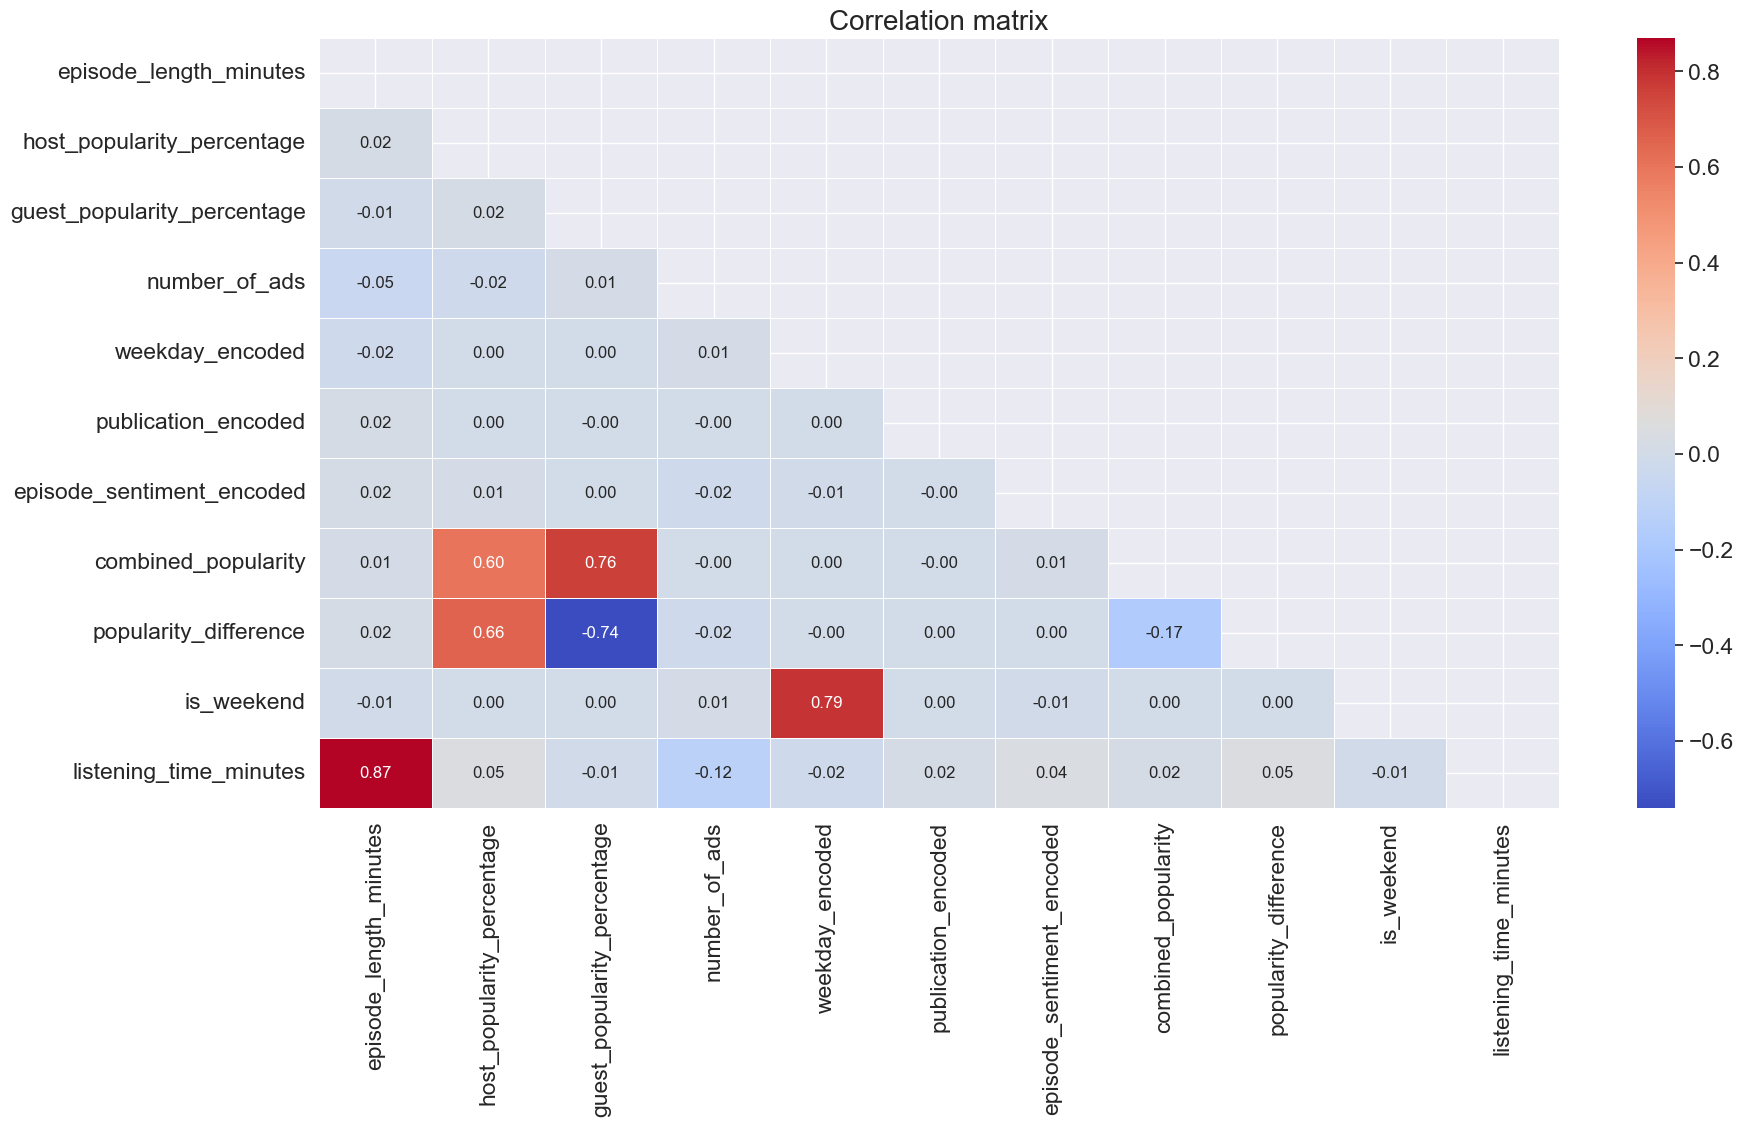

In [16]:
num_corr = round(train.corr(), 2)

# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

f, ax = plt.subplots(figsize=(20, 10))
sns.set_theme(font_scale=1.5) # increase font size

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlation matrix", fontsize=20) # add title
plt.show()

In [18]:
train = train.drop(columns=['host_popularity_percentage', 'guest_popularity_percentage', 'weekday_encoded'])
test = test.drop(columns=['host_popularity_percentage', 'guest_popularity_percentage', 'weekday_encoded'])

train

,episode_length_minutes,number_of_ads,publication_encoded,episode_sentiment_encoded,combined_popularity,popularity_difference,is_weekend,listening_time_minutes
0,63.84,0.0,4,2,40.083198,21.23,0,31.41998
1,119.80,2.0,1,0,50.848525,-9.00,1,88.01241
2,73.90,0.0,2,0,6.276309,61.00,0,44.92531
3,67.17,2.0,0,2,45.032140,-21.48,0,46.27824
4,110.51,3.0,1,1,46.985076,21.39,0,75.61031
...,...,...,...,...,...,...,...,...
749995,75.66,0.0,0,0,37.163088,15.78,1,56.87058
749996,75.75,2.0,4,1,18.865518,-18.37,1,45.46242
749997,30.98,0.0,0,0,66.706562,-6.31,0,15.26000
749998,108.98,0.0,0,0,42.335253,-47.88,0,100.72939


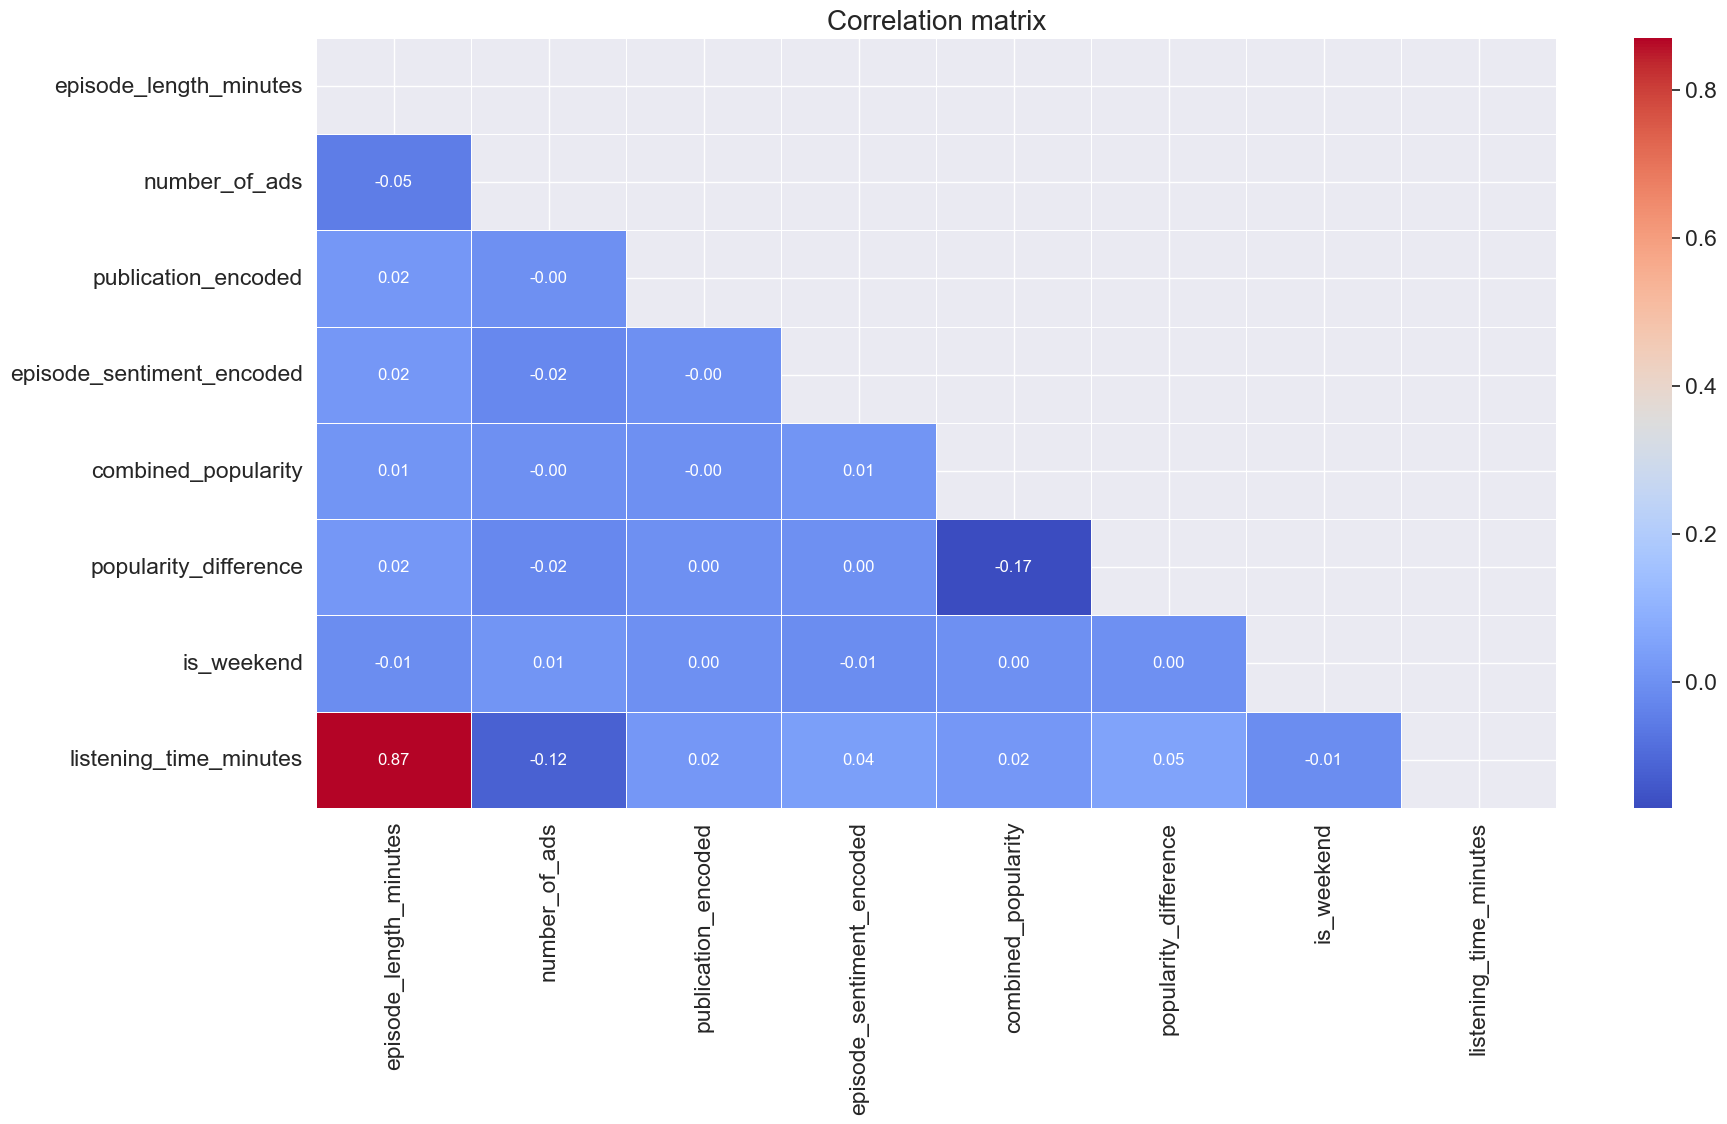

In [19]:
num_corr = round(train.corr(), 2)

# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

f, ax = plt.subplots(figsize=(20, 10))
sns.set_theme(font_scale=1.5) # increase font size

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlation matrix", fontsize=20) # add title
plt.show()

In [20]:
from sklearn.model_selection import train_test_split

X = train.drop(columns='listening_time_minutes') #target
y = train['listening_time_minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [22]:
def train_and_eval_models(X_train, X_test, y_train, y_test):

    #models to test
    models = {
        "Linear Regression" : LinearRegression(),
        "Random Forest" : RandomForestRegressor(),
        "XGB" : XGBRegressor()
    }

    print("Starting the training process.")

    #list to store results

    results = []

    #scaling data just for LogisticRegression

    for name, model in models.items():
        print(f"Training model: {name}")

        model.fit(X_train, y_train)

        y_train_predict = model.predict(X_train)
        y_test_predict = model.predict(X_test)

        results.append({
            "Model": name,
            "Train MAE": mean_absolute_error(y_train, y_train_predict),
            "Test MAE": mean_absolute_error(y_test, y_test_predict),
            "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_predict)),
            "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_predict)),
            "Train R2": r2_score(y_train, y_train_predict),
            "Test R2": r2_score(y_test, y_test_predict)
        })

    # Converting results into a DataFrame
    results_df = pd.DataFrame(results)

    print("\nModel Performance Summary:")
    print(results_df)

    return results_df

In [23]:
results_df = train_and_eval_models(X_train, X_test, y_train, y_test)

print(results_df)

Starting the training process.
Training model: Linear Regression
Training model: Random Forest
Training model: XGB

Model Performance Summary:
               Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2  \
0  Linear Regression   9.826032  9.775440   13.384722  13.352680  0.756804   
1      Random Forest   3.427843  9.199174    4.928868  13.087065  0.967021   
2                XGB   9.466904  9.536616   12.999326  13.118821  0.770607   

    Test R2  
0  0.757696  
1  0.767240  
2  0.766109  
               Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2  \
0  Linear Regression   9.826032  9.775440   13.384722  13.352680  0.756804   
1      Random Forest   3.427843  9.199174    4.928868  13.087065  0.967021   
2                XGB   9.466904  9.536616   12.999326  13.118821  0.770607   

    Test R2  
0  0.757696  
1  0.767240  
2  0.766109  


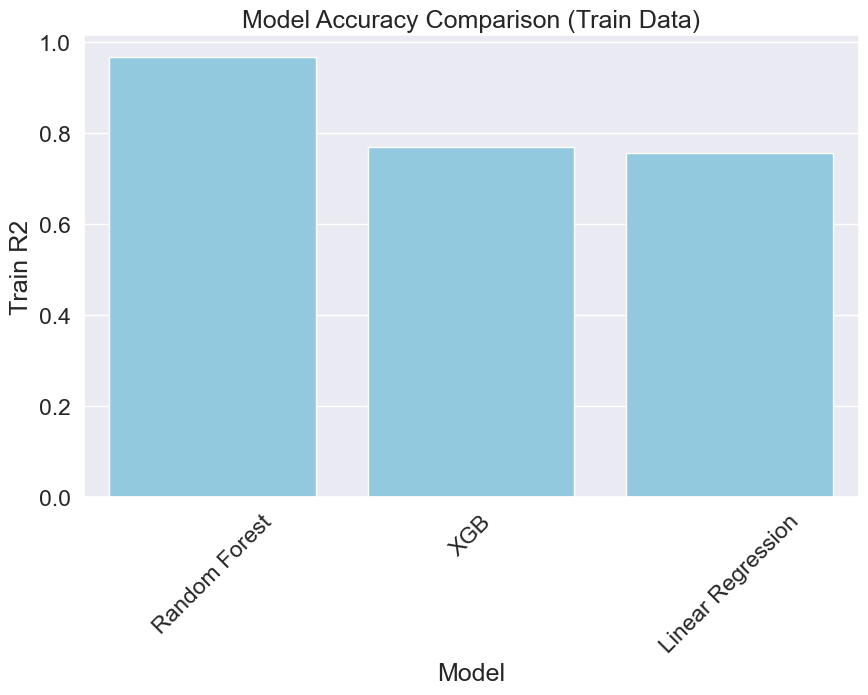

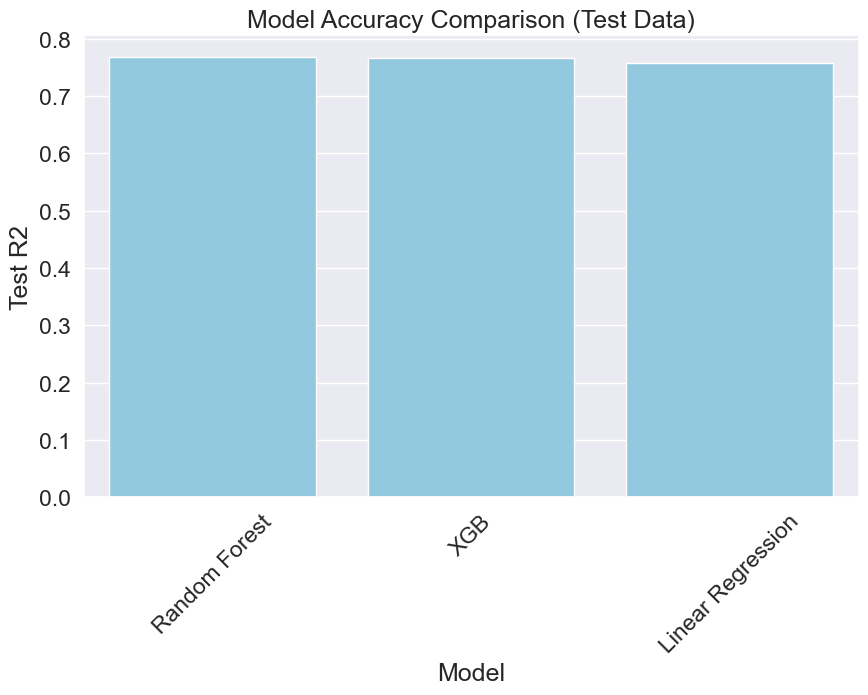

In [24]:
#plotting the results

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Train R2", data=results_df.sort_values(by='Train R2', ascending=False), color='skyblue')
plt.title("Model Accuracy Comparison (Train Data)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Test R2", data=results_df.sort_values(by='Test R2', ascending=False), color='skyblue')
plt.title("Model Accuracy Comparison (Test Data)")
plt.xticks(rotation=45)
plt.show()

In [25]:
def xgbhyper(X_train, X_test, y_train, y_test):

    #models to test
    models = {
        "XGB" : XGBRegressor(max_depth= 3)
    }

    print("Starting the training process.")

    #list to store results

    results = []

    #scaling data just for LogisticRegression

    for name, model in models.items():
        print(f"Training model: {name}")

        model.fit(X_train, y_train)

        y_train_predict = model.predict(X_train)
        y_test_predict = model.predict(X_test)

        results.append({
            "Model": name,
            "Train MAE": mean_absolute_error(y_train, y_train_predict),
            "Test MAE": mean_absolute_error(y_test, y_test_predict),
            "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_predict)),
            "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_predict)),
            "Train R2": r2_score(y_train, y_train_predict),
            "Test R2": r2_score(y_test, y_test_predict)
        })

    # Converting results into a DataFrame
    results_df = pd.DataFrame(results)

    print("\nModel Performance Summary:")
    print(results_df)

    return results_df

In [26]:
results_xgb_df = xgbhyper(X_train, X_test, y_train, y_test)

print(results_xgb_df)

Starting the training process.
Training model: XGB

Model Performance Summary:
  Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2   Test R2
0   XGB   9.614179  9.580797   13.185086     13.154  0.764004  0.764853
  Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2   Test R2
0   XGB   9.614179  9.580797   13.185086     13.154  0.764004  0.764853
